# LoRa Data Analysis - Upper Confidence Bound


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages.
- were sending a single message each 2 minutes.
- used an upper confidence bound algorithm (UCB) for communication parameters selection.

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [96]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
uplink_message_file = './18/uplink_messages.csv'
algorithm = 'ucb'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [97]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [98]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,102854,NzA3Ni44LDEzNTkuMQ==,2.5,-99.9,36000,t,2021-04-10 09:40:22.512,1,866100000,7,10,58,4/5,125000,124,1,111111,t3w0
1,102855,NTc4My4zLDQ5MDkuNw==,-17.4,-66.5,36000,t,2021-04-10 09:40:27.567,1,866100000,7,10,58,4/5,125000,111,2,111111,j6eI
2,102856,NzU4LjgsNjEzNS43,-12.6,-100.8,36000,t,2021-04-10 09:40:32.565,1,866100000,7,10,52,4/5,125000,155,2,111111,Qihc
3,102857,Njc2NC45LDMwNjAuMg==,-12.6,-90.5,36000,t,2021-04-10 09:40:38.065,1,866100000,7,10,58,4/5,125000,193,1,111111,iOK8
4,102858,OTExMy4xLDI4OTAuOA==,-17.6,-101.9,36000,t,2021-04-10 09:40:43.606,1,866100000,7,10,58,4/5,125000,252,1,111111,96VU


Remove all columns that have fixed values or there is no point in their analysis.

In [99]:
try:
    del uplink_data['id']
    del uplink_data['msg_group_number']
    del uplink_data['is_primary']
    del uplink_data['coderate']
    del uplink_data['bandwidth']
    del uplink_data['receive_time']
except KeyError:
    print('Columns have already been removed')

Let us create a new column 'arm'. This columns represents a combination of SF and TP and is referred in multi-armed bandit terminology as arm.

In [100]:
uplink_data['arm'] = 'S' + uplink_data.spf.astype(str) + 'P' + uplink_data.power.astype(str)

### Communication parameters selection

In [101]:
arms = uplink_data.arm.value_counts()
threshold = round(statistics.mean(uplink_data.arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold} will be cut from a plot')
arms = arms[arms > threshold]

Values below 16.17 will be cut from a plot


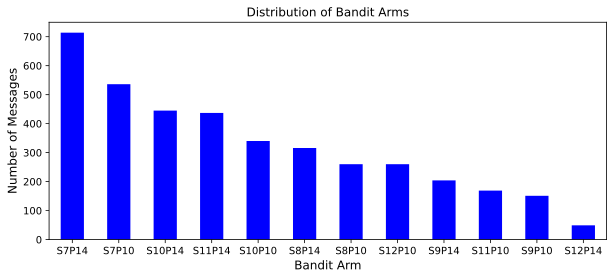

In [139]:
hist = arms.plot(kind='bar',rot=0, color='b',figsize=(10,4))
hist.set_xlabel('Bandit Arm',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title('Distribution of Bandit Arms')
plt.savefig(f'{algorithm}-bandit-arms.svg', dpi=300)
plt.show()

### Spreading Factor

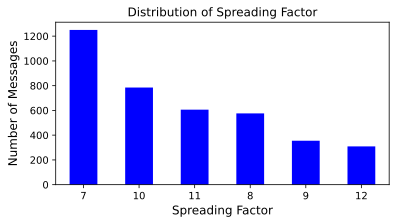

In [105]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='b',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title('Distribution of Spreading Factor')
plt.show()

All nodes used the same frequency to increase a probability of collisions.

We have only a single Access Point.

### Duration of Data Transmission

In [66]:
airtime = uplink_data.airtime.value_counts()
threshold = 100
airtime = airtime.loc[lambda x : x > threshold]
print(f'Values with low then {threshold} occurences will be cut from a plot')

Values with low then 100 occurences will be cut from a plot


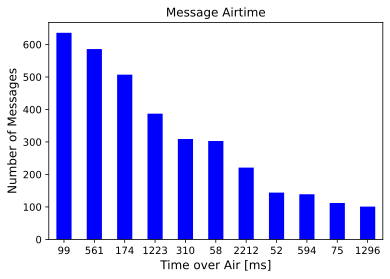

In [138]:
hist = airtime.plot(kind='bar',rot=0,color='b')
hist.set_xlabel('Time over Air [ms]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title('Message Airtime')
plt.savefig(f'{algorithm}-airtime.svg', dpi=300)
plt.show()

### Transmission Power

Only two transmission power values were possible in this scenario.

To increase TP a value of 14 was used, to decrease TP a value of 10 was used.

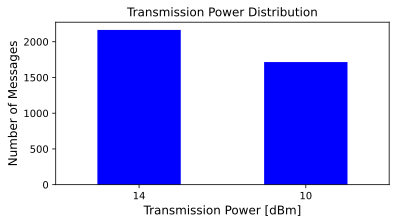

In [108]:
hist = uplink_data.power.value_counts().plot(kind='bar',rot=0,color='b',figsize=(6,3))
hist.set_xlabel('Transmission Power [dBm]', fontsize=12)
hist.set_ylabel('Number of Messages', fontsize=12)

plt.title('Transmission Power Distribution')
plt.show()

### Different Types of Messages

Let us analyze the ratio of message types.

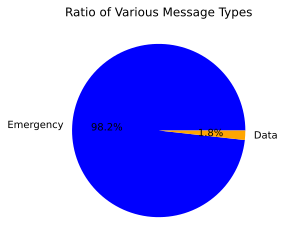

In [124]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Emergency', 'Data'], colors=['b', 'orange'])
plt.title('Ratio of Various Message Types')

# Output is automatically exported
plt.savefig(f'{algorithm}-message-types.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [110]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 88.


In [111]:
uplink_data.node_id.describe()

count     3881
unique      88
top       WtAl
freq        77
Name: node_id, dtype: object

In [113]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 88
Total number of connected access points: 1


In [122]:
end_nodes = pd.read_csv(f'./18/{algorithm} - experiment - 18 - 1.csv', delimiter=',')

In [123]:
end_nodes.head()

,dev_id,active_time,uptime,collisions
0,nn66,0.16,24.28,2
1,jLn5,1.16,24.29,1
2,Hh7f,0.00,24.28,1
3,VGHy,0.21,24.31,2
4,xhil,0.16,24.33,4


### Collision Histogram

Cutting values is disabled.

In [116]:
no_collisions = end_nodes.collisions.value_counts()
threshold = statistics.mean(end_nodes.collisions.value_counts())
print(f'Values below {threshold} will be cut in a plot')

Values below 6.6 will be cut in a plot


In [117]:
collisions = end_nodes.collisions[end_nodes.collisions > threshold]
collisions.describe()

count    29.000000
mean      9.517241
std       3.066183
min       7.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      22.000000
Name: collisions, dtype: float64

In [118]:
max_collisions = max(collisions)
min_collisions = min(collisions)
range_collisions = max_collisions - min_collisions
increment = math.ceil(range_collisions / 4)

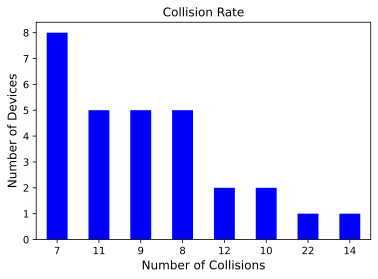

In [121]:
# out = pd.cut(collisions, bins=[min_collisions, min_collisions + increment, min_collisions + 2 * increment, min_collisions + 3 * increment, max(collisions)], include_lowest=True)
hist = collisions.value_counts().plot.bar(rot=0,color='b')
hist.set_xlabel('Number of Collisions',fontsize=12)
hist.set_ylabel('Number of Devices',fontsize=12)
plt.title('Collision Rate')
plt.savefig(f'{algorithm}-collisions.svg', dpi=300)
plt.show()

In [127]:
mean_collisions = round(statistics.mean(collisions))
print(f'Mean collision number for each node was {mean_collisions}.')

Mean collision number for each node was 10.


### Ration between active time and total nodes uptime

In [128]:
energy = (end_nodes.active_time / end_nodes.uptime)
energy.describe()

count    99.000000
mean      0.024966
std       0.033963
min       0.000000
25%       0.002008
50%       0.010497
75%       0.041973
max       0.193291
dtype: float64

In [129]:
active_time = round(statistics.mean(energy) * 100, 2)
print(f'The nodes spent {active_time}% of their uptime in active mode.')

The nodes spent 2.5% of their uptime in active mode.


## Path of Each End Node

Data about position are encoded as base64.

Decode base64, extract position and save the results to original data frame.

In [130]:
try:
    app_data = uplink_data.app_data.apply(base64.b64decode)
    app_data = app_data.astype(str)
    app_data = app_data.str.split(',')

    df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])

    x = []
    y = []

    for row in app_data:
        x.append(round(float(row[1].split('\'')[0]), 2))
        y.append(round(float(row[0].split('\'')[1]), 2))

    uplink_data['x'] = x
    uplink_data['y'] = y
    
    del uplink_data['app_data']
except KeyError:
    print('Column has already been removed')

In [131]:
uplink_data.head()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id,node_id,arm,x,y
0,2.5,-99.9,36000,1,866100000,7,10,58,1,111111,t3w0,S7P10,1359.1,7076.8
1,-17.4,-66.5,36000,1,866100000,7,10,58,2,111111,j6eI,S7P10,4909.7,5783.3
2,-12.6,-100.8,36000,1,866100000,7,10,52,2,111111,Qihc,S7P10,6135.7,758.8
3,-12.6,-90.5,36000,1,866100000,7,10,58,1,111111,iOK8,S7P10,3060.2,6764.9
4,-17.6,-101.9,36000,1,866100000,7,10,58,1,111111,96VU,S7P10,2890.8,9113.1


Now, we draw a path for each end node based on the received coordinates.

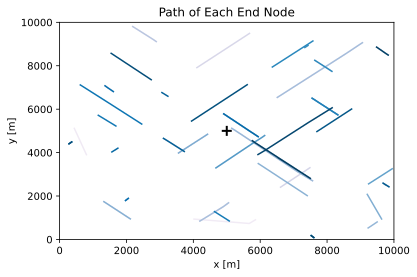

In [141]:
unique_ens = len(uplink_data.node_id.unique())
cmap = mpl.cm.get_cmap('PuBu')
xlim = 10000
ylim = 10000

for i in range(0, unique_ens):
    data = uplink_data[uplink_data.node_id == uplink_data.node_id[i]]
    plt.plot(data.x, data.y, color=cmap(i / unique_ens))
    
# Add Access Point
plt.plot(xlim / 2, ylim / 2, '+', mew=10, ms=2, color='black')

plt.title('Path of Each End Node')
plt.ylabel('y [m]')
plt.xlabel('x [m]')

plt.xlim([0,xlim])
plt.ylim([0,ylim])

# Figure is automatically saved
plt.savefig(f'{algorithm}-path.svg', dpi=300)
plt.show()